# Conv1D Autoencoder를 사용한 시계열 data 이상 감지

In [42]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, Dropout, Conv1DTranspose
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

## Load the data

비정상적인 동작 기간이 labeling 된  인공 시계열 데이터
[Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) 를 사용합니다. 데이터는 정열되고 타임스탬프가 지정된 단일 값 메트릭입니다.

학습에는 `art_daily_small_noise.csv` 파일을 사용하고 테스트에는 `art_daily_jumpsup.csv` 파일을 사용합니다. 이 데이터 세트의 단순성 덕분에 이상 탐지를 효과적으로 시연할 수 있습니다.

In [43]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

print(df_small_noise.shape, df_daily_jumpsup.shape)

(4032, 1) (4032, 1)


In [44]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


## data 시각화
### 정상 시계열 데이터

- 정상 데이터를 autoencoder 훈련에 사용합니다.

<AxesSubplot:xlabel='timestamp'>

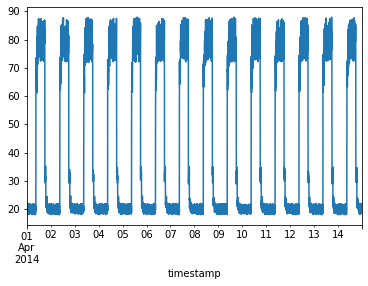

In [45]:
df_small_noise.plot(legend=False)

### 이상이 있는 시계열 데이터

정상 데이터로 훈련된 autoencoder 모델의 테스트를 위해 다음 데이터를 사용하고, 데이터의 갑작스러운 점프가 이상으로 감지되는지 확인합니다.

<AxesSubplot:xlabel='timestamp'>

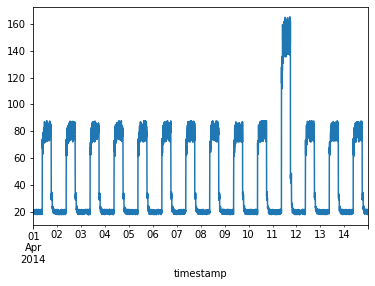

In [46]:
df_daily_jumpsup.plot(legend=False)

## 훈련 데이터 준비

훈련 시계열 데이터 파일(`df_small_noise`)에서 데이터 값을 가져오고 `value` 데이터를 정규화 합니다. 14일 동안 5분마다 `value`가 있습니다.

-   24일 * 60분 / 5분 = **288 timesteps per day**
-   288 timesteps per day * 14일 = **total 4032 data points** 

In [47]:
# 테스트 데이터를 정규화하기 위해 평균과 표준 편차를 정규화하고 저장합니다.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
# standard scaling
df_training_value = (df_small_noise - training_mean) / training_std

print("훈련 샘플 수:", len(df_training_value))

훈련 샘플 수: 4032


### 시퀀스 data 생성

훈련 데이터에서 `TIME_STEPS` 연속 데이터 값을 조합하여 시퀀스를 생성합니다.

In [48]:
TIME_STEPS = 288

# 모델에서 사용하기 위해 생성된 훈련 시퀀스
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

X_train = create_sequences(df_training_value.values)
print("Training input shape: ", X_train.shape)

Training input shape:  (3745, 288, 1)


## Build a model

컨볼루션 재구성 오토인코더 모델을 구축합니다. 모델은 `(batch_size, sequence_length, num_features)`  shape의 입력을 받고 동일한 shape의 출력을 반환합니다. 이 경우 `sequence_length`는 288이고 `num_features`는 1입니다.

In [49]:
X_train.shape[1], X_train.shape[2]

(288, 1)

In [50]:
model = keras.Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        Dropout(rate=0.2),
        Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
        Dropout(rate=0.2),
        Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
        Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        Conv1DTranspose(filters=1, kernel_size=1, padding="same"),
    ])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 dropout_3 (Dropout)         (None, 72, 16)            0         
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 144, 16)          1808      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                            

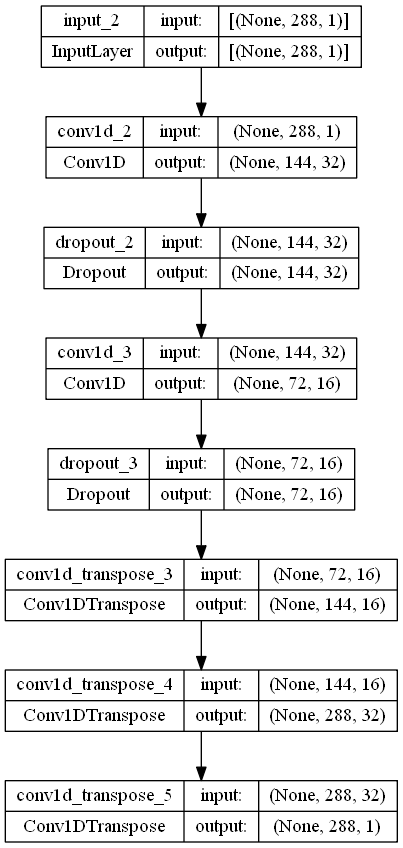

In [51]:
plot_model(model, show_shapes=True)

## 모델 train

재구성 모델이기 때문에 입력과 대상 모두로 `X_train`을 사용하고 있습니다.

In [52]:
history = model.fit(
    X_train, X_train,
    epochs=50, batch_size=128, validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 1s 35ms/step - loss: 0.6851 - val_loss: 0.1001
Epoch 2/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0918 - val_loss: 0.0430
Epoch 3/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0588 - val_loss: 0.0347
Epoch 4/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0506 - val_loss: 0.0311
Epoch 5/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0441 - val_loss: 0.0288
Epoch 6/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0389 - val_loss: 0.0275
Epoch 7/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0357 - val_loss: 0.0267
Epoch 8/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0331 - val_loss: 0.0262
Epoch 9/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0310 - val_loss: 0.0271
Epoch 10/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0293 - val_loss: 0.0266
Epoch 11/

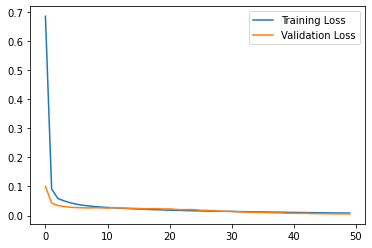

In [53]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## 이상 감지

모델이 입력 데이터를 얼마나 잘 재구성할 수 있는지 결정하여 이상을 감지합니다.

1.   훈련 샘플에서 MAE 손실을 찾습니다.
2.   최대 MAE 손실 값을 찾습니다. 이것은 우리 모델이 샘플을 재구성하기 위해 수행한 최악의 작업입니다. 이를 이상 감지의 `threshold`로 설정합니다.
3.   샘플의 재구성 손실이 이 `threshold` 보다 크면 모델이 익숙하지 않은 패턴을 보고 있다고 추론할 수 있습니다. 우리는 이 샘플을 `anomaly`로 분류할 것입니다.

- MAE 손실 시각화

118/118 [==============================] - 1s 4ms/step


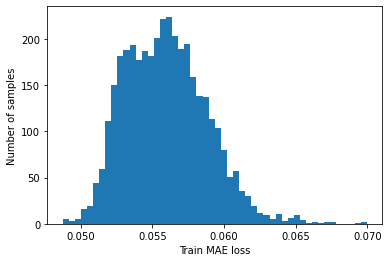

In [54]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of samples")
plt.show()

- train set의 최대 MAE 손실을 재구성 손실 임계값으로 정합니다.

In [55]:
threshold = np.max(train_mae_loss)
print("재구성 오류 임계값: ", threshold)

재구성 오류 임계값:  0.06996866479673751


### 재구성 비교

재미 삼아 우리 모델이 첫 번째 샘플을 어떻게 재구성했는지 봅니다.
이것은 훈련 데이터 세트 1일차의 288개 timestep 입니다.

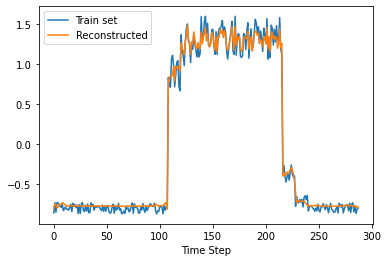

In [56]:
# 첫 번째 시퀀스가  어떻게 학습되었는지 확인
plt.plot(X_train[0], label='Train set')
plt.plot(X_train_pred[0], label='Reconstructed')
plt.xlabel("Time Step")
plt.legend()

### 테스트 데이터 준비
- test set을 standard scale  
- 시각화

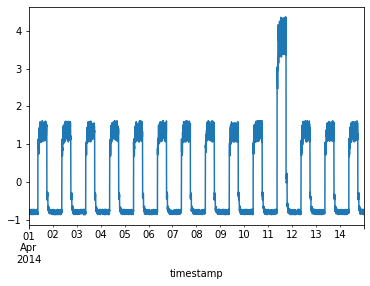

In [57]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

- Test set에서 시퀀스 data 생성

In [58]:
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


- test set의 MAE loss 구하기

In [59]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

118/118 [==============================] - 0s 4ms/step


- MAE 손실 시각화

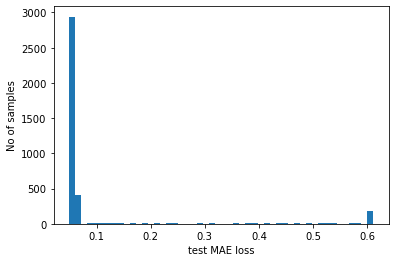

In [60]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

- 모든 이상 샘플 감지

In [61]:
anomalies = test_mae_loss > threshold
print("이상 감지된 샘플 수: ", np.sum(anomalies))
print("이상 감지된 샘플의 인덱스: ", np.where(anomalies))

이상 감지된 샘플 수:  398
이상 감지된 샘플의 인덱스:  (array([1657, 2521, 2522, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708,
       2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719,
       2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730,
       2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741,
       2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752,
       2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763,
       2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774,
       2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785,
       2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796,
       2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807,
       2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818,
       2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829,
       2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840,
       2841, 28

## 이상치 plot

이제 우리는 비정상 데이터 샘플을 알고 있습니다. 이를 통해 원본 테스트 데이터에서 해당 `timestamps`를 찾을 수 있습니다. 이를 위해 다음 방법을 사용할 것입니다.

time_steps = 3이고 10개의 훈련 값이 있다고 가정해 보겠습니다. 우리의 `X_train`은 다음과 같이 보일 것입니다:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

초기 및 마지막 time_steps-1 데이터 값을 제외한 모든 값은 `time_steps` 샘플 수로 표시됩니다. 따라서 샘플 [(3, 4, 5), (4, 5, 6), (5, 6, 7)]이 비정상이라는 것을 안다면 데이터 포인트 5가 비정상이라고 말할 수 있습니다.  

그러므로 `TIME_STEPS`기간 전체 샘플 `[(i - timesteps + 1) ~ (i)]`이 비정상인 경우 데이터 `i`는 비정상으로 분류할 수 있습니다.

In [62]:
index = 2754
np.all(anomalies[index: 2754+TIME_STEPS])  # index => 비정상

True

In [63]:
anomalous_data_indices = []

for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

원본 테스트 데이터 플롯에 이상치를 오버레이해 시각화

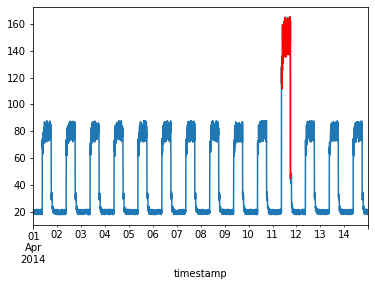

In [64]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]

fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()